In [1]:
# install.packages('cowplot')
# install.packages('rjags')
# install.packages('showtext')
# install.packages('BayesianTools')

# Important equations
Full width at half maximum:
$$
\text{FWHM} = \sqrt{w_{d}^{2} + w_{e}^2}
$$


Device resolution
$$
w_d = 2\sqrt{\left(2\ln 2\right) \cdot F \cdot E_{\gamma} \cdot w}
$$

# Initialize libs, data, useful functions

In [2]:
library(tidyverse)
library(cowplot)
library(magrittr)
library('rjags')
library(showtext)
library(BayesianTools)
fig <- function(width, height){
     options(repr.plot.width = width, repr.plot.height = height)
}



th_path = 'data/IC48A_Th.txt'
AmCsCo_path = 'data/IC48A_AmCsCo.txt'

th_data = read.table(th_path, col.names = c('Ch', 'counts'))
th_peaks = c(238.632, 300.089, 510.74, 583.187, 727.330, 763.45, 785.37, 860.53, 893.408, 1078.63, 1512.70, 1592.511, 1620.738, 2103.511, 2614.511)

acc_data = read.table(AmCsCo_path, col.names = c('Ch', 'counts'))
acc_peaks = c(59.5409, 661.657, 1173.228, 1332.492, 2505.69)


calc_fwhm <- function(wd, we) {
    return(sqrt(wd^2 + we^2))
}
calc_wd <- function(fano, E_ph, w) {
    return(2*sqrt(2*log(2)*fano*E_ph*w))
}

── Attaching packages ───────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ──────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract


Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs

Loading required package: sysfonts

Loading required package: showtextdb



# Plot raw data

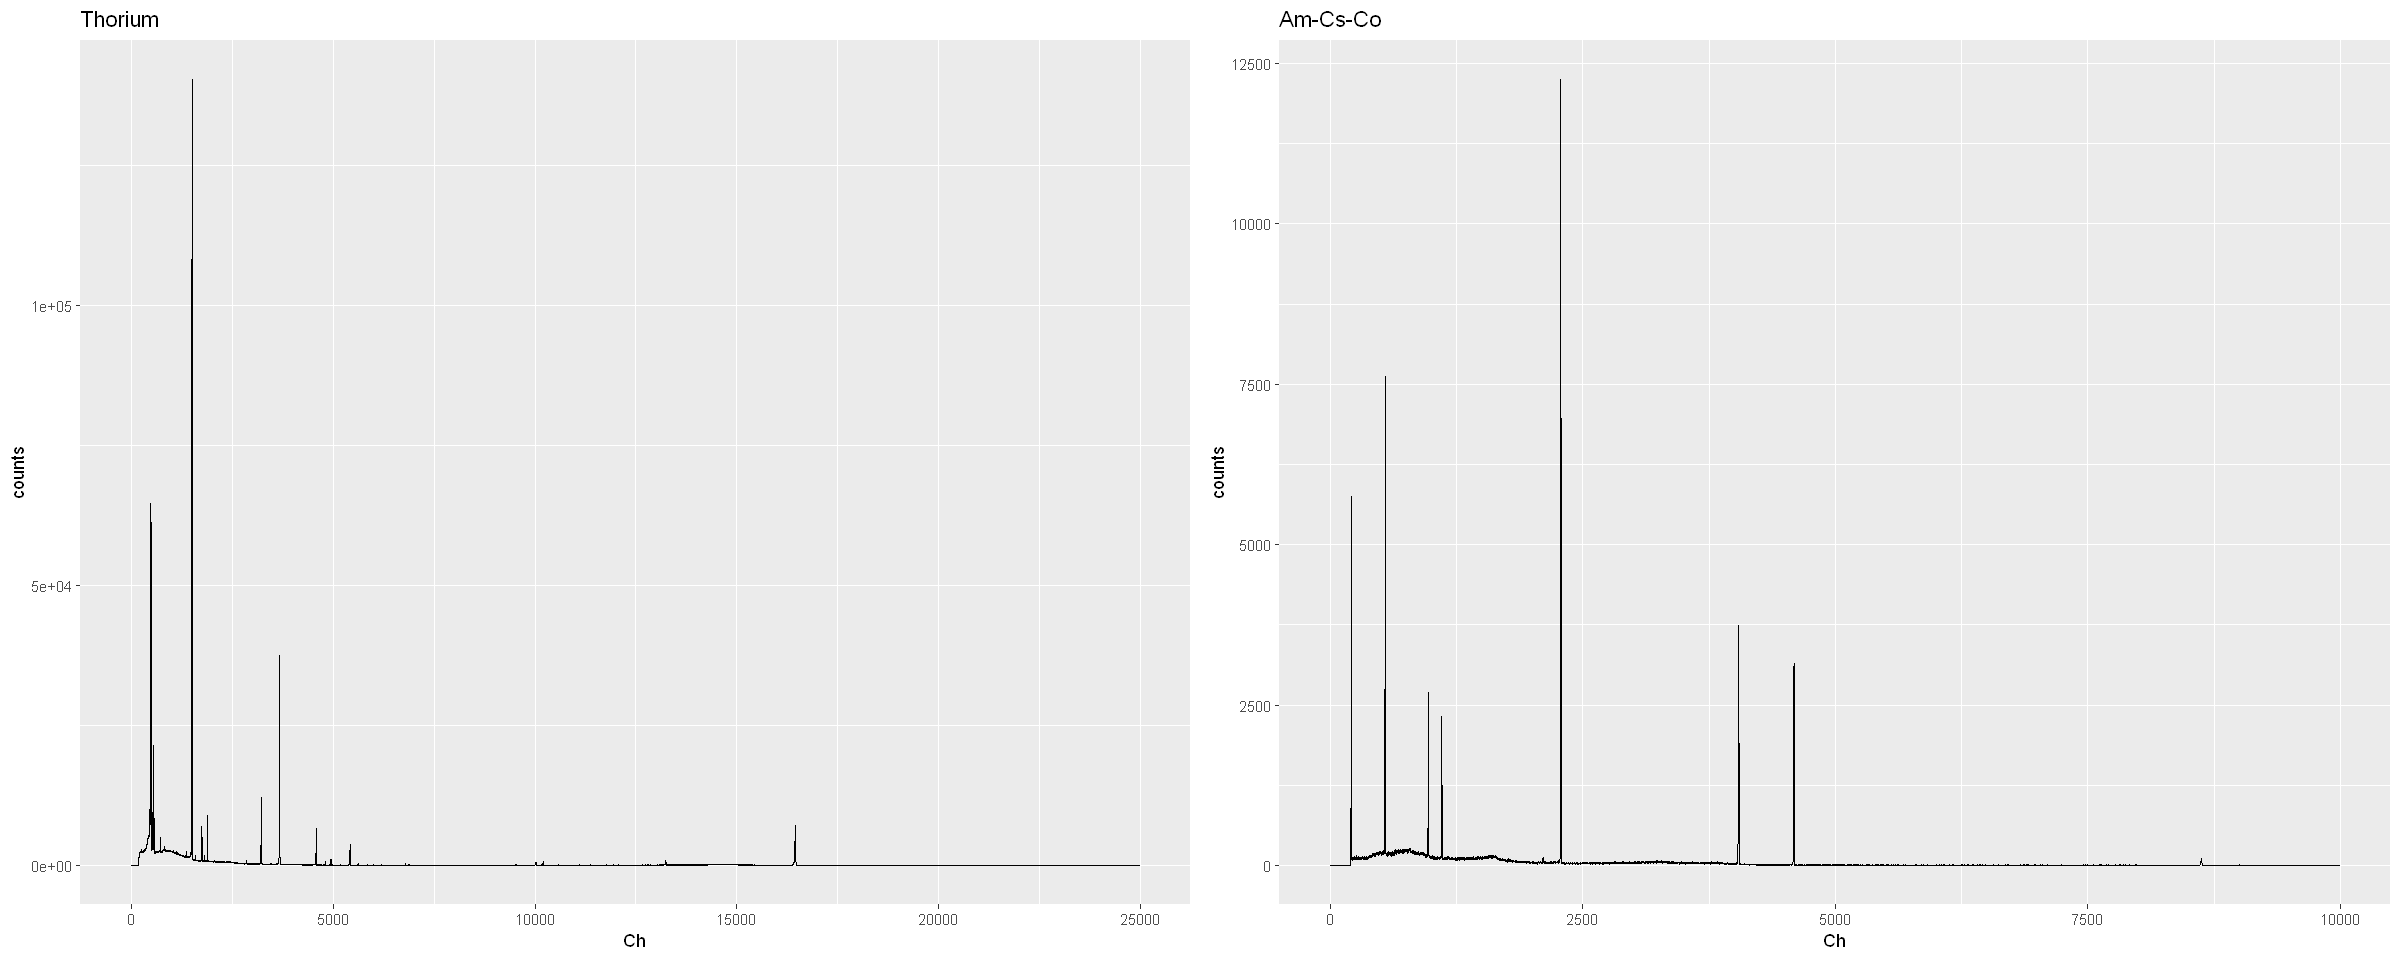

In [3]:
fig(20,8)

p_th = ggplot(data = th_data, mapping = aes(x = Ch, y = counts)) + 
    geom_line() +
    ggtitle('Thorium')

p_acc = ggplot(data = acc_data, mapping = aes(x = Ch, y = counts)) + 
    geom_line() +
    ggtitle('Am-Cs-Co')

plot_grid(p_th, p_acc)

In [2]:
# Crop and center peaks into individual arrays

In [71]:
#Functions to probe peaks and output dataframe with each peak in data centered.

range_size <- function(data){
    return(max(data) - min(data))    
}

peak_shift <- function(peak_array){
    peak_idx <- which.max(peak_array)
    peak_y <- c(peak_array[(peak_idx-10):(peak_idx+10)])
    return(peak_y)
}

fetch_ch <- function(peak_array){
    peak_idx <- which.max(peak_array)
    idx_c <- c((peak_idx-10):(peak_idx+10))
    return(idx_c)
}

probe_peaks <- function(data, n.pts){
    
    data_range <- split(data$counts, ceiling(row(data)/n.pts))
    ch_range <- split(data$Ch, ceiling(row(data)/n.pts))
    
    minmax_range <- lapply(data_range, range_size)
    peaks <- data_range[minmax_range > 3500]
    ch_vals <- ch_range[minmax_range > 3500]
    
    ly <- lapply(peaks, peak_shift)
    lx <- lapply(peaks, fetch_ch)
    
    centered_ch <- bind_cols(lx)
    colnames(centered_ch) = paste('X', 1:length(lx), sep = '')
    
    centered_peaks <- bind_cols(ly)
    colnames(centered_peaks) = paste('Y',1:length(ly), sep = '')
    
    centered_ch %<>% cbind(centered_peaks)
    return(centered_ch)
}

centered_peaks <- probe_peaks(acc_data, 80)# %>% pivot_longer(!x_vals, values_to = c('counts'), names_to='peak')

Warning message in split.default(data$counts, ceiling(row(data)/n.pts)):
"data length is not a multiple of split variable"
Warning message in split.default(data$Ch, ceiling(row(data)/n.pts)):
"data length is not a multiple of split variable"


In [72]:
centered_peaks

X1,X2,X3,X4,Y1,Y2,Y3,Y4
<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
37,54,31,33,0,221,72,50
38,55,32,34,0,204,76,74
39,56,33,35,1,227,96,128
40,57,34,36,0,230,108,239
41,58,35,37,1,205,219,434
42,59,36,38,3,256,586,777
43,60,37,39,48,547,1400,1528
44,61,38,40,328,1570,3304,2232
45,62,39,41,1458,3904,6290,3065


In [75]:
#ggplot(data = centered_peaks, mapping = aes(x = c(X1, X2, X3, X4), y = c(Y1, Y2, Y3, Y4))) + geom_line()

### Plot peaks

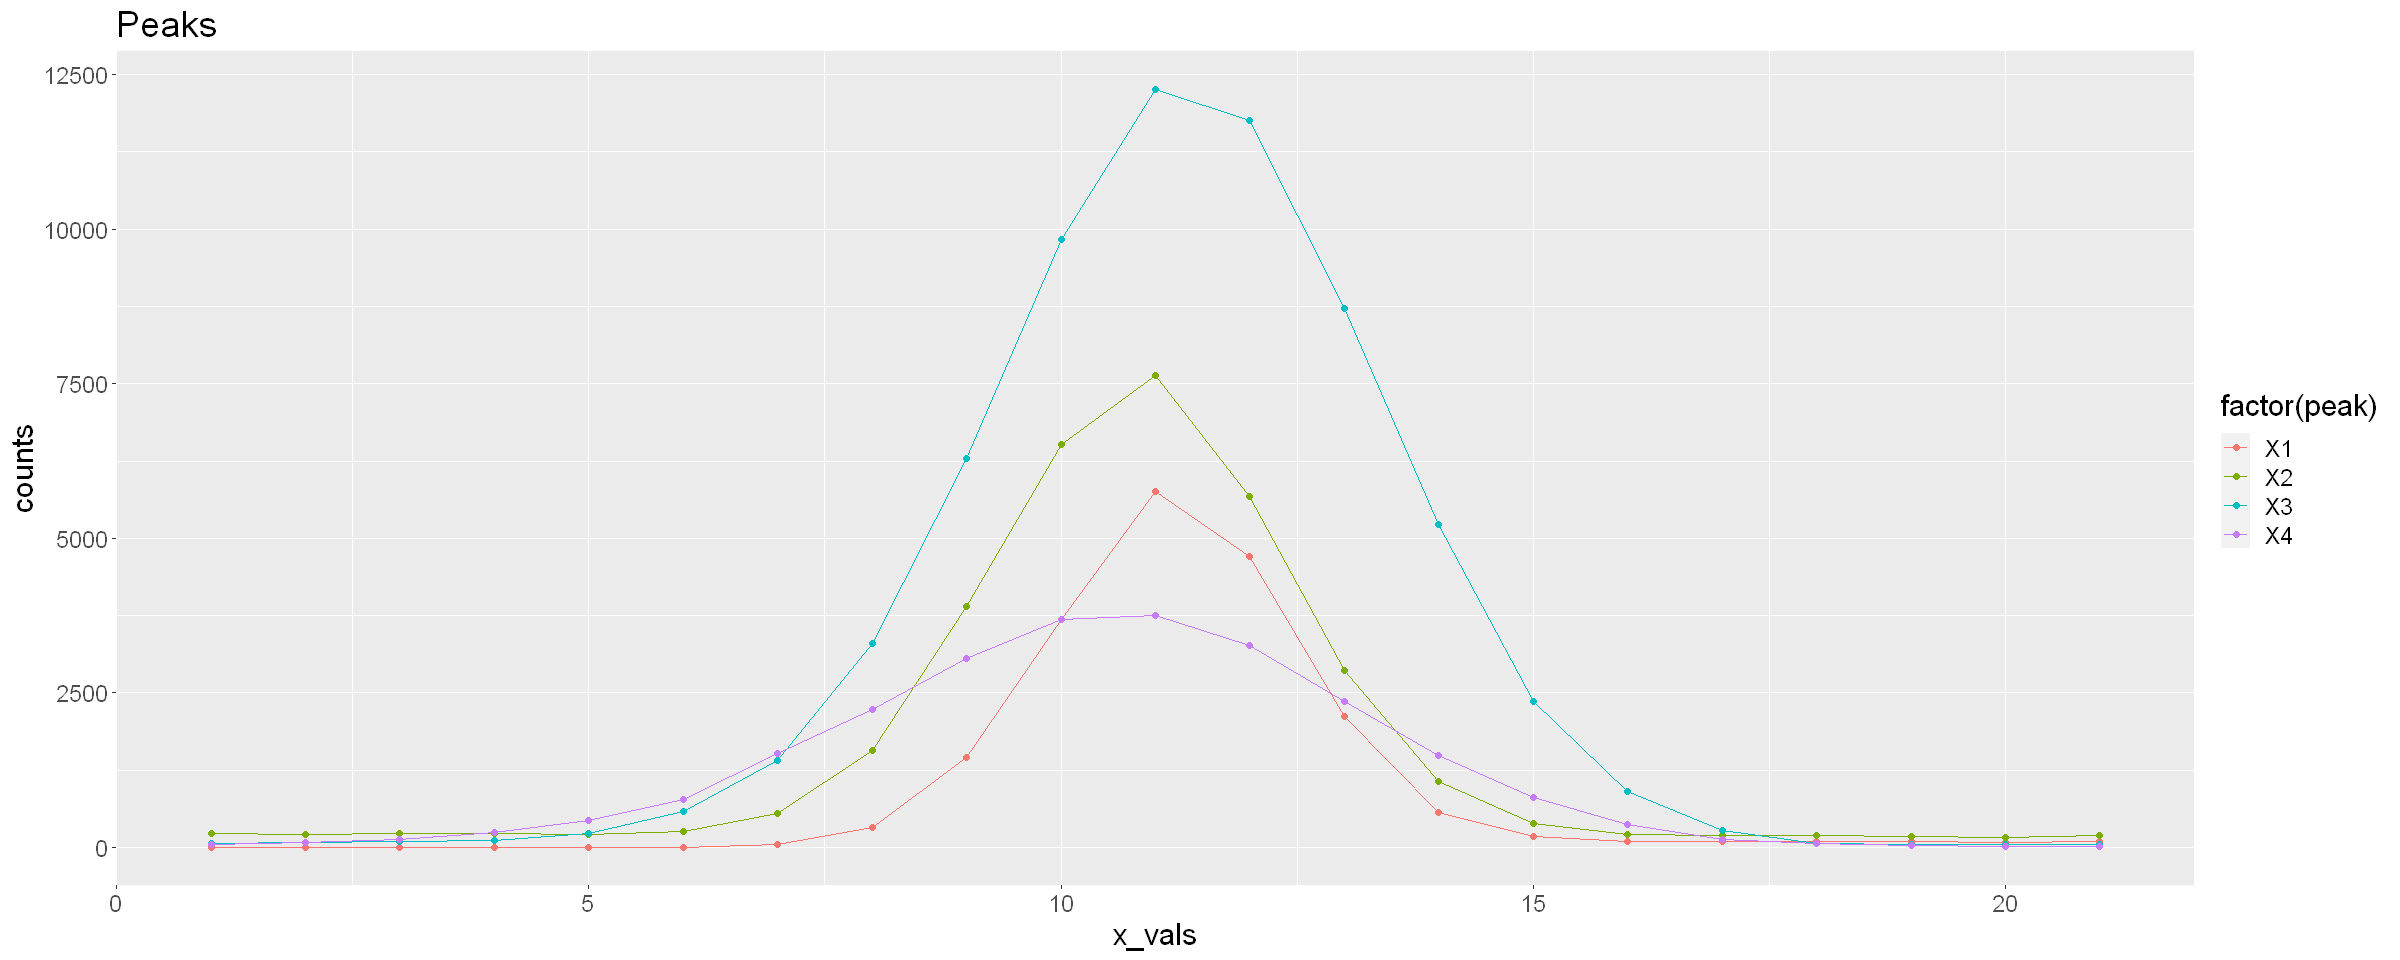

In [25]:
#fig(15, 8)
peak_plot <- ggplot(data = centered_peaks, mapping = aes(x = x_vals, y = counts, color = factor(peak))) + geom_line() + geom_point() + theme(text=element_text(size = 18)) + ggtitle('Peaks')
print(peak_plot)

In [26]:
centered_peaks

x_vals,peak,counts
<int>,<chr>,<dbl>
1,X1,0
1,X2,221
1,X3,72
1,X4,50
2,X1,0
2,X2,204
2,X3,76
2,X4,74
3,X1,1
